In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score,learning_curve, validation_curve
# train_test_split: chia dữ liệu thành tập huấn luyện và kiểm tra.

# cross_val_score: đánh giá mô hình bằng cross-validation.

# learning_curve: trực quan hoá hiệu suất mô hình theo lượng dữ liệu học.

# validation_curve: xem ảnh hưởng của một tham số tới hiệu suất mô hình.
from sklearn.feature_extraction.text import TfidfVectorizer #chuyển văn bản thành dạng số (vector) dựa trên tần suất và độ quan trọng của từ trong tài liệu kỹ thuật TF-IDF.
from sklearn import svm, naive_bayes,metrics
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score, precision_score, recall_score
# confusion_matrix: ma trận hiển thị số lần dự đoán đúng/sai từng lớp.

# accuracy_score: độ chính xác.

# f1_score: trung bình hài hoà giữa precision và recall.

# precision_score: tỷ lệ đúng trên các dự đoán là spam.

# recall_score: tỷ lệ đúng trên các email thực sự là spam.


from nltk.stem import LancasterStemmer
# LancasterStemmer: dùng để rút gọn từ về gốc (stem), ví dụ "running", "runs", "ran" về "run".
import nltk
nltk.download("punkt")  #bộ tách câu và từ (tokenizer).
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize #để tách câu thành các từ riêng biệt Ví dụ: "this is spam" → ["this", "is", "spam"]
from sklearn.model_selection import train_test_split as ttsplit
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [78]:
#Thực hiện load dữ liệu từ google drive
from google.colab import drive
drive.mount('/content/drive')
#Thực hiện load dữ liệu từ dataset file
df = pd.read_csv("/content/drive/My Drive/AI/mail_data.csv")
message_X = df.iloc[:,1] #Gán cột EmailText
labels_Y = df.iloc[:,0]  #Gán cột Label

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


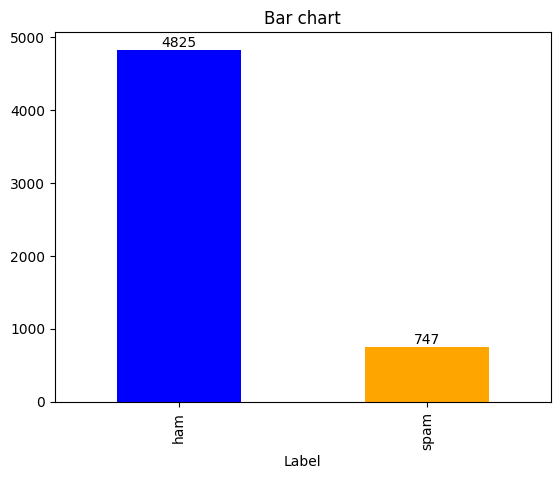

In [ ]:
import matplotlib.pyplot as plt

# Thống kê
count_Class = df["Label"].value_counts(sort=True)

# Vẽ bar chart và trả về Axes
# ax: là đối tượng Axes của biểu đồ – dùng để thêm chú thích hoặc tinh chỉnh biểu đồ.
ax = count_Class.plot(kind='bar', color=["blue","orange"])

# Duyệt qua từng thanh bar và thêm label
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        str(int(height)),                 # text là giá trị
        (p.get_x() + p.get_width()/2, height),  # vị trí: giữa thanh, trên đỉnh
        ha='center', va='bottom'
    )

plt.title('Bar chart')
plt.show()

In [ ]:
### Tiền xử lí văn bản làm sạch và chuẩn hóa nội dung email 
# Hàm mess() sẽ:

# Làm sạch dữ liệu email.

# Tách từ.

# Rút gọn từ về gốc (stemming).
# => Kết quả là một danh sách các văn bản đã được xử lý.
#Khởi tạo biến
lstem = LancasterStemmer()
def mess(messages):
  message_x = []
  for me_x in messages:
    #Lọc dữ liệu ngoài trừ bảng chữ cái
    me_x=''.join(filter(lambda mes:(mes.isalpha() or mes==" ") ,me_x))
    #Chia nhỏ các body email thành các từ
    words = word_tokenize(me_x)
    #Nhóm các từ gốc lại
    message_x+=[' '.join([lstem.stem(word) for word in words])]
    # Với mỗi từ đã tách ra, thực hiện rút gọn về gốc từ bằng lstem.stem(word).


  return message_x #Trả về danh sách các email đã được làm sạch, tách từ, và chuẩn hóa gốc từ.

In [ ]:
#  biến văn bản thành dữ liệu số để học máy xử lý được.
# message_X là danh sách email (nội dung email gốc)
message_x = mess(message_X)
#Xử lí các túi từ, vector hóa, bỏ các từ dừng stopwords không cần thiết
# TF (Term Frequency): tần suất xuất hiện của từ trong tài liệu.
# IDF (Inverse Document Frequency): mức độ hiếm của từ trong toàn bộ tập dữ liệu.
# Giúp tăng trọng số cho từ đặc trưng, giảm ảnh hưởng từ phổ biến (như “the”, “is”...)
tfvec=TfidfVectorizer(stop_words='english')
#vectorizing feature data
#Đưa dữ liệu về vector
x_new=tfvec.fit_transform(message_x).toarray()
# fit: học tất cả các từ xuất hiện trong message_x (tạo từ điển).
# transform: biến từng văn bản thành vector số dựa trên trọng số TF-IDF của từng từ.
# .toarray():
# Chuyển dữ liệu từ định dạng sparse matrix (dạng ma trận thưa) sang mảng đầy đủ (numpy array) để dễ thao tác.
# Giả sử 2 email sau:
# ["I love spam emails", "Spam emails are annoying"]
# TF-IDF sẽ tạo một ma trận như sau (giả sử từ điển gồm: "love", "spam", "emails", "annoying"):

# Email	                        love	spam	emails	annoying
# "I love spam emails"        	1.0	    0.7  	0.7	    0.0
# "Spam emails are annoying"	0.0	    0.5	    0.5	    1.0


In [ ]:
#Chuyển đổi ham và spam thành giá trị 0 và 1
y_new = np.array(labels_Y.replace(to_replace=['ham', 'spam'], value=[0, 1]))
# Chuyển kết quả sau .replace() (Series của pandas) thành mảng NumPy.

<ipython-input-83-24925be4a822>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_new = np.array(labels_Y.replace(to_replace=['ham', 'spam'], value=[0, 1]))


In [ ]:

# Tách dataset thành dữ liệu training và testing
x_train , x_test , y_train , y_test = ttsplit(x_new,y_new,test_size=0.2,random_state=1)
# Dùng random_state để đảm bảo kết quả chia dữ liệu có thể lặp lại

In [ ]:

# Tìm kiếm tham số tối ưu cho SVM với GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# 1. Khởi tạo model SVM
svm = SVC()

# 2. Định nghĩa các giá trị hyperparameter cần thử nghiệm
param_grid = {
    'C': [0.1 ,1 ,10, 100],
    'kernel': ['linear', 'poly'],

}

# 3. Tìm kiếm tham số tối ưu bằng GridSearchCV kết hợp cross-validation
grid_search = GridSearchCV(
    estimator=svm,        # Model cần tối ưu
    param_grid=param_grid, # Các giá trị tham số sẽ thử nghiệm
    cv=3                  # 3-fold cross-validation
)
grid_search.fit(x_train, y_train)  # Huấn luyện với dữ liệu train





GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'poly']})

In [67]:
# 4. Lấy bộ tham số tốt nhất và điểm cross-validation tốt nhất
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Best Hyperparameters: {'C': 1, 'kernel': 'linear'}
Best Cross-Validation Score: 0.9771138935338127


In [68]:
# 5. Huấn luyện lại SVM với bộ tham số tối ưu trên toàn bộ dữ liệu train
best_svm = SVC(**best_params)
best_svm.fit(x_train, y_train)

SVC(C=1, kernel='linear')

In [85]:
# Sử dụng các model để phân loại
classifier = svm.SVC(kernel='linear')
# classifier=LogisticRegression()
# classifier=MultinomialNB()
# Use cross-validation to assess the model's performance on unseen data
# scores = cross_val_score(classifier, x_train, y_train, cv=5)
# print("Cross-validation accuracy: ", scores.mean(), "+/-", scores.std())
classifier.fit(x_train,y_train)

SVC(kernel='linear')

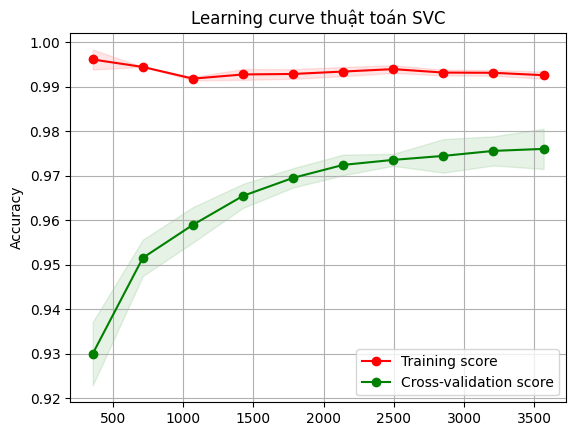

In [31]:
#Định nghĩa range cho training size
train_sizes = np.linspace(0.1, 1.0, 10)
# Sử dụng learning curve cho SVM model
train_sizes, train_scores, val_scores = learning_curve(classifier, x_train, y_train, train_sizes=train_sizes, cv=5)
# Tính giá trị trung bình và độ lệch cho training và validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)
# Vẽ curve
plt.figure()
plt.title('Learning curve thuật toán SVC')
plt.ylabel("Accuracy")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [86]:
#Tính toán các giá trị test
Accuracy=accuracy_score(y_test, classifier.predict(x_test))
Precision=precision_score(y_test, classifier.predict(x_test))
Recall=recall_score(y_test, classifier.predict(x_test))
F1_Score=f1_score(y_test, classifier.predict(x_test))
print('Accuracy : {:.2f}%'.format(Accuracy*100))
print('Precision : {:.2f}%' .format(Precision*100))
print('Recall : {:.2f}%'.format(Recall*100))
print('F1-Score : {:.2f}%'.format(F1_Score*100))


Accuracy : 97.94%
Precision : 98.44%
Recall : 85.71%
F1-Score : 91.64%


In [87]:
#Tính toán confusion
m_confusion_test = metrics.confusion_matrix(y_test, classifier.predict(x_test))
pd.DataFrame(data = m_confusion_test, columns = ['Dự Đoán (Ham)', 'Dự đoán (Spam)'],
            index = ['Thực tế (Ham)', 'Thực tế (Spam)'])

,Dự Đoán (Ham),Dự đoán (Spam)
Thực tế (Ham),966,2
Thực tế (Spam),21,126


Confusion Matrix is : 
 [[966   2]
 [ 39 108]]


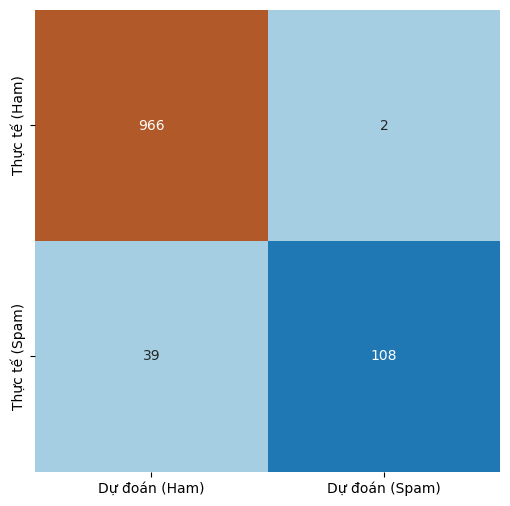

In [ ]:
#Vẽ lên biểu đồ
import seaborn as sns
cmat = confusion_matrix(y_test, classifier.predict(x_test))
print('Confusion Matrix is : \n', cmat)
plt.figure(figsize = (6, 6))
sns.heatmap(cmat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Dự đoán (Ham)', 'Dự đoán (Spam)'], yticklabels=['Thực tế (Ham)', 'Thực tế (Spam)']);